In [46]:
import json
import numpy as np
from matplotlib import pyplot as plt

In [47]:
# PATH = "data/2024-11-09_11-10-06-algific"
# PATH = "data/2024-11-09_13-11-13-premotion"
# PATH = "data/2024-11-09_13-11-13-premotion/"
# PATH = "data/2024-11-10_16-28-30-chemotropic"  # With Numpy 1.x
# PATH = "data/2024-11-10_16-38-20-nephratonia"  # With Numpy 2.x
# PATH = "data/2024-11-10_23-09-26-brachyphyllum"  # With 100 rollouts
# PATH = "data/2024-11-11_10-48-13-microsporidia/"  # With 100 rollouts
# PATH = "data/2024-11-11_10-50-19-perchloride/" # with 500 rollouts
# PATH = "data/2024-11-11_11-55-02-turriculate/" # with fast rollouts 20% of the time
# PATH = "data/2024-11-11_12-44-39-cephalopterus/"

PATH = "data/2024-11-11_13-31-42-gasterolichenes"

In [48]:
# data/1731122195-monosiphonous - My first long run
# data/2024-11-09_11-10-06-algific - Ran with large cache
# data/2024-11-09_13-11-13-premotion - Ran with no cache

events = []
with open(f"../{PATH}/logs.txt") as f:
    logs = f.readlines()
    for line in logs:
        # Skip lines that are not events.
        if not line.startswith("event | "):
            continue

        _, timestamp, event, params = line.strip().split(" | ")
        events.append((float(timestamp), event, json.loads(params)))

# Sort events by timestamp.
events.sort(key=lambda x: x[0])

# Adjust timestamps to start at 0.
start_time = events[0][0]
events = [
    (timestamp - start_time, event, params)
    for timestamp, event, params in events
]


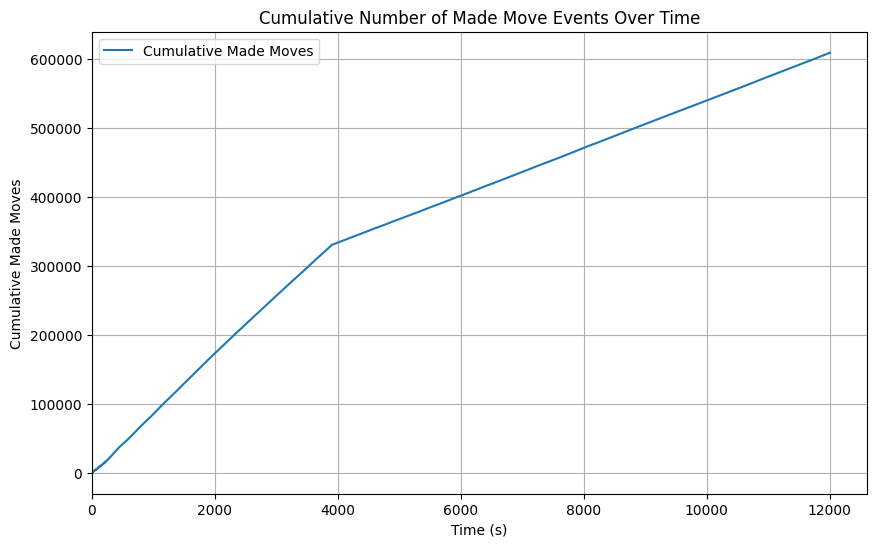

Time to first move: 12.018594741821289


In [49]:
timestamps = [event[0] for event in events if event[1] == "made_move"]
indices = [i for i, event in enumerate(events) if event[1] == "made_move"]
cumulative_made_moves = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_made_moves, label='Cumulative Made Moves')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Made Moves')
plt.title('Cumulative Number of Made Move Events Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()

print(f"Time to first move: {min(timestamps)}")

In [50]:
print("Number of moves", max(cumulative_made_moves))

Number of moves 608890


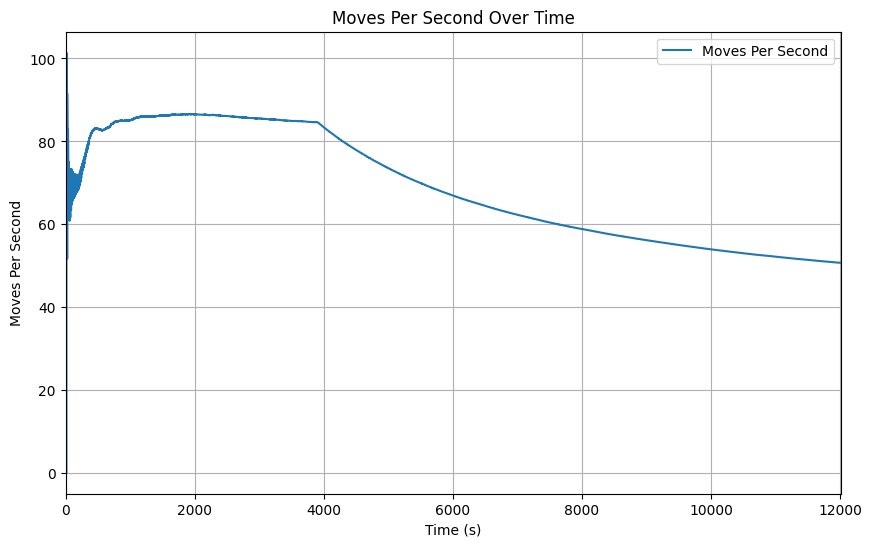

Maximal moves per second during latter half: 84.90515043382783


In [51]:
moves_per_second = []

moves_made = 0
for event in events:
    if event[1] != "made_move":
        continue
    moves_made += 1

    moves_per_second.append(moves_made / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "made_move"], moves_per_second, label='Moves Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Moves Per Second')
plt.title('Moves Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

final_moves_per_sec = max(
    moves_per_second[len(moves_per_second) // 2:]
)
print("Maximal moves per second during latter half:", final_moves_per_sec)

In [52]:
total_duration = 0
total_evaluated = 0
for event in events:
    if event[1] == "gpu_evaluation":
        total_duration += event[2]["duration"]
        total_evaluated += event[2]["batch_size"]

# GPU bottleneck. Closer to 1 means that the GPU is the bottleneck because the
# moves per second we actually got is close to the theoretical maximum based on
# GPU evaluation speed.
# 
# This won't work when using caching.
print("speed relative to if GPU was fully utilized:", final_moves_per_sec / ((total_evaluated / total_duration) / (500 * 0.2 + 100 * 0.8)))

speed relative to if GPU was fully utilized: 1.9452796243076107


In [53]:
# What percent of time is the GPU thread being used?

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
print("percent GPU utilization:", total_duration / (max(evaluations) - min(evaluations)))

percent GPU utilization: 0.9138730001169878


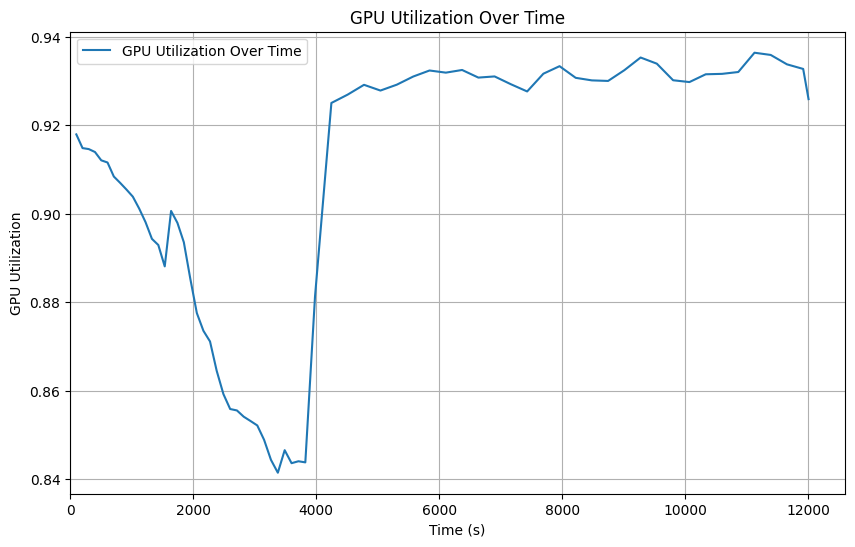

In [55]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

gpu_utilization = []
times = []

window_size = 10000

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    time_interval = evaluations_in_window[-1][0] - evaluations_in_window[0][0]
    duration = sum(event[2]["duration"] for event in evaluations_in_window)

    gpu_utilization.append(duration / time_interval)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.plot(times, gpu_utilization, label='GPU Utilization Over Time')
plt.xlabel('Time (s)')
plt.ylabel('GPU Utilization')
plt.title('GPU Utilization Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()


In [34]:
events[500000][0]

2625.7037360668182

In [38]:
events[600_000][0]

3178.7855207920074

In [36]:

filtered_events = events[400_000:600_000]
# filtered_events = events[1_000_000:]

evaluations = [event for event in filtered_events if event[1] == "gpu_evaluation"]
timestamps = [event[0] for event in evaluations]
total_duration = sum([event[2]["duration"] for event in evaluations])

print("percent GPU utilization:", total_duration / (max(timestamps) - min(timestamps)))

percent GPU utilization: 0.8579668827372003


In [11]:
# What is the average batch size?

batch_sizes = [event[2]["batch_size"] for event in events if event[1] == "gpu_evaluation"]
sum(batch_sizes) / len(batch_sizes)

128.0

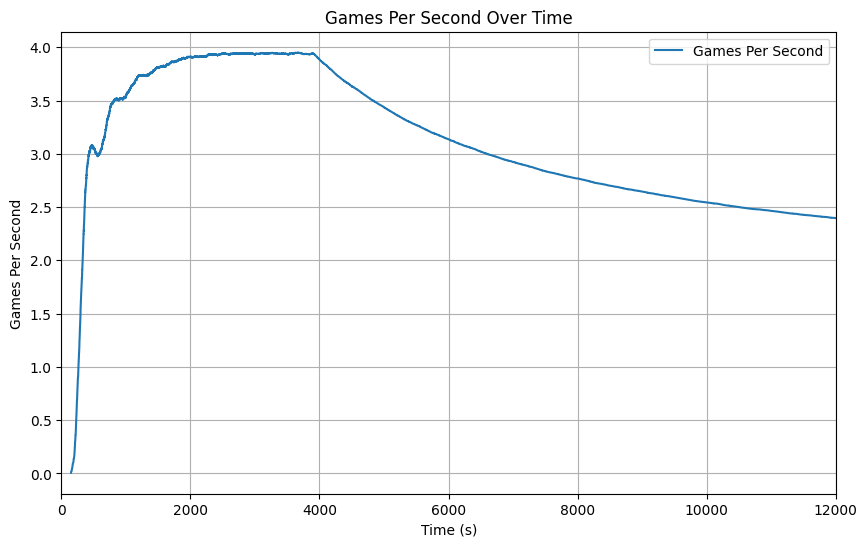

In [12]:
games_per_second = []

games_finished = 0
for event in events:
    if event[1] != "game_end":
        continue
    games_finished += 1

    games_per_second.append(games_finished / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "game_end"], games_per_second, label='Games Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Games Per Second')
plt.title('Games Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

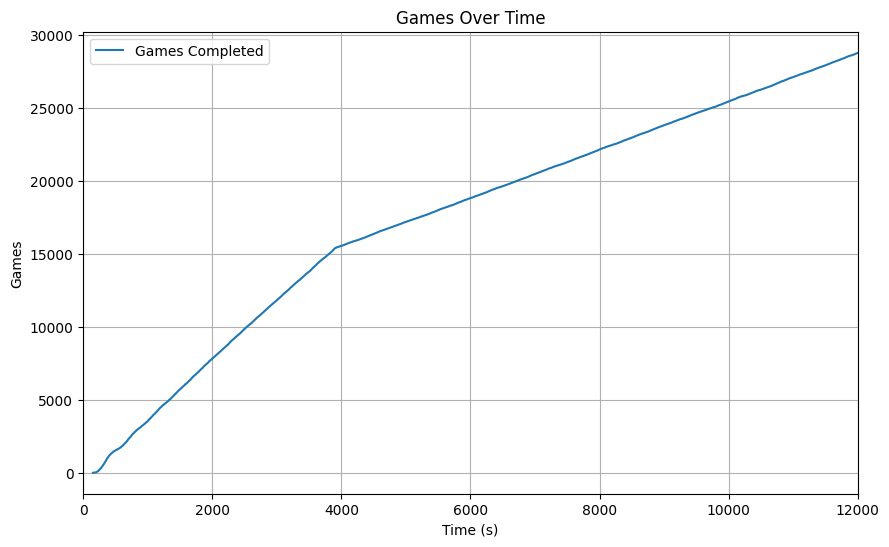

In [13]:
games_finished = 0
games_finished_counts = []
for event in events:
    if event[1] != "game_end":
        continue
    games_finished += 1
    games_finished_counts.append(games_finished)

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "game_end"], games_finished_counts, label='Games Completed')
plt.xlabel('Time (s)')
plt.ylabel('Games')
plt.title('Games Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

In [25]:
import scipy.stats

In [ ]:
# Prepare the data for linear regression
x = [event[0] for event in events if event[1] == "game_end"][:7000]
y = games_finished_counts[:7000]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x, [slope * xi + intercept for xi in x], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Games Finished')
plt.title('Linear Regression of Games Finished Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Prepare the data for linear regression
x_made_move = [event[0] for event in events if event[1] == "made_move"][:18]
y_made_move = [i for i, event in enumerate(events) if event[1] == "made_move"]

# Perform linear regression
slope_made_move, intercept_made_move, r_value_made_move, p_value_made_move, std_err_made_move = scipy.stats.linregress(x_made_move, y_made_move)

# Print the results
print(f"Slope: {slope_made_move}")
print(f"Intercept: {intercept_made_move}")
print(f"R-squared: {r_value_made_move**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x_made_move, y_made_move, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x_made_move, [slope_made_move * xi + intercept_made_move for xi in x_made_move], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Moves Made')
plt.title('Linear Regression of Moves Made Over Time')
plt.legend()
plt.grid(True)
plt.show()

